In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset"

In [ ]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import glob
import matplotlib.pyplot as plt
import cv2

In [ ]:
train = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Train" 
val ="/content/drive/MyDrive/COVID-19_Radiography_Dataset/Val"
test = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Test"

gen_train = ImageDataGenerator(rescale = 1./255., zoom_range = 0.2,)
gen_val = ImageDataGenerator(rescale = 1./255.)
gen_test = ImageDataGenerator(rescale = 1./255.)

train_gen = gen_train.flow_from_directory(train, batch_size=64, class_mode='binary', target_size=(220, 220))
validation_gen = gen_val.flow_from_directory(val, batch_size=64, class_mode='binary', target_size=(220, 220))
test_gen = gen_test.flow_from_directory(test, shuffle=False, batch_size=64, class_mode='binary', target_size=(220, 220))

Found 5786 images belonging to 2 classes.
Found 722 images belonging to 2 classes.
Found 722 images belonging to 2 classes.


Batch images shape: (64, 220, 220, 3)
Batch labels shape: (64,)


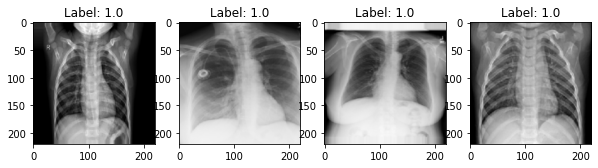

In [ ]:
# Get a batch of images and labels from train_gen
batch_images, batch_labels = next(train_gen)

# Print the shape of the batch images and labels
print('Batch images shape:', batch_images.shape)
print('Batch labels shape:', batch_labels.shape)

import matplotlib.pyplot as plt

# Plot the first 4 images in the batch
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    axes[i].imshow(batch_images[i])
    axes[i].set_title(f'Label: {batch_labels[i]}')
plt.show()


In [ ]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', input_shape=(220, 220, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 524,801
Non-trainable params: 20,861,480
____________________________________

In [ ]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen, validation_data = validation_gen, steps_per_epoch = 32, epochs = 10)

Epoch 1/10
32/32 [==============================] - 41s 1s/step - loss: 0.3092 - accuracy: 0.8687 - val_loss: 0.3077 - val_accuracy: 0.8587
Epoch 2/10
32/32 [==============================] - 41s 1s/step - loss: 0.2934 - accuracy: 0.8613 - val_loss: 0.2186 - val_accuracy: 0.9017
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.2977 - accuracy: 0.8696 - val_loss: 0.1554 - val_accuracy: 0.9349
Epoch 4/10
32/32 [==============================] - 36s 1s/step - loss: 0.3057 - accuracy: 0.8746 - val_loss: 0.3424 - val_accuracy: 0.8338
Epoch 5/10
32/32 [==============================] - 35s 1s/step - loss: 0.2966 - accuracy: 0.8692 - val_loss: 0.2385 - val_accuracy: 0.8837
Epoch 6/10
32/32 [==============================] - 37s 1s/step - loss: 0.2475 - accuracy: 0.8984 - val_loss: 0.3199 - val_accuracy: 0.8546
Epoch 7/10
32/32 [==============================] - 35s 1s/step - loss: 0.2403 - accuracy: 0.9045 - val_loss: 0.3157 - val_accuracy: 0.8490
Epoch 8/10
32/32 [==

In [ ]:
model.save("Xception_model.h5")

In [ ]:
history_array = np.array([history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy']])

# Save the numpy array to an npy file
np.save('history.npy', history_array)

In [ ]:
loss, accuracy = model.evaluate(test_gen)

# print the loss and accuracy values
print('Test loss:', loss)
print('Test accuracy:', accuracy)

12/12 [==============================] - 177s 16s/step - loss: 0.3699 - accuracy: 0.8186
Test loss: 0.36989626288414
Test accuracy: 0.8185595273971558


In [ ]:
loss, accuracy = model.evaluate(train_gen)

# print the loss and accuracy values
print('Train loss:', loss)
print('Train accuracy:', accuracy)

91/91 [==============================] - 89s 978ms/step - loss: 0.2262 - accuracy: 0.9048
Train loss: 0.2262001782655716
Train accuracy: 0.9047701358795166


In [ ]:
loss, accuracy = model.evaluate(validation_gen)

# print the loss and accuracy values
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

12/12 [==============================] - 4s 301ms/step - loss: 0.2605 - accuracy: 0.8684
Validation loss: 0.2605370879173279
Validation accuracy: 0.8684210777282715


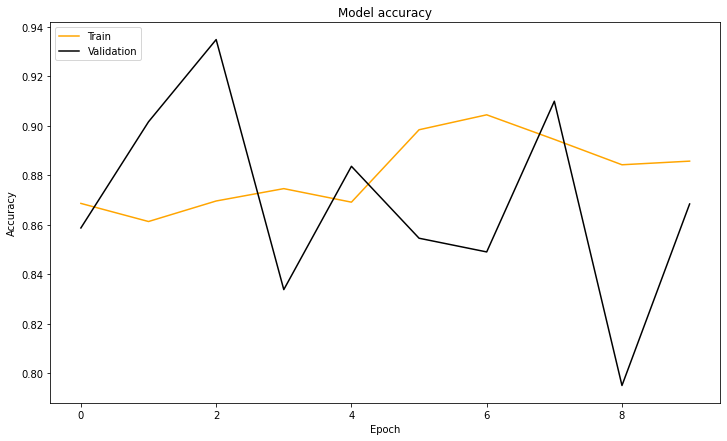

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(history.history['accuracy'], c = "orange")
ax.plot(history.history['val_accuracy'], c = "black")
ax.set_title('Model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

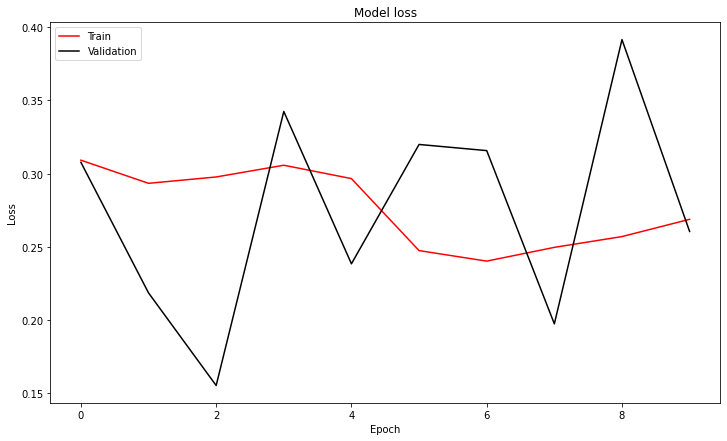

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(history.history['loss'], c ="red")
ax.plot(history.history['val_loss'], c = "black")
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', input_shape=(220, 220, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 524,801
Non-trainable params: 20,861,480
____________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
history1 = model.fit(train_gen, validation_data = validation_gen, steps_per_epoch = 32, epochs = 10, callbacks=[checkpoint])
best_model = model.load_weights('best_model.h5')

Epoch 1/10
32/32 [==============================] - 40s 1s/step - loss: 0.4428 - accuracy: 0.7827 - val_loss: 0.2980 - val_accuracy: 0.8504
Epoch 2/10
32/32 [==============================] - 34s 1s/step - loss: 0.3273 - accuracy: 0.8511 - val_loss: 0.4155 - val_accuracy: 0.7784
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.3173 - accuracy: 0.8662 - val_loss: 0.2227 - val_accuracy: 0.8947
Epoch 4/10
32/32 [==============================] - 37s 1s/step - loss: 0.2973 - accuracy: 0.8726 - val_loss: 0.2793 - val_accuracy: 0.8615
Epoch 5/10
32/32 [==============================] - 37s 1s/step - loss: 0.2929 - accuracy: 0.8781 - val_loss: 0.2892 - val_accuracy: 0.8518
Epoch 6/10
32/32 [==============================] - 34s 1s/step - loss: 0.2854 - accuracy: 0.8816 - val_loss: 0.2897 - val_accuracy: 0.8601
Epoch 7/10
32/32 [==============================] - 37s 1s/step - loss: 0.2786 - accuracy: 0.8771 - val_loss: 0.3150 - val_accuracy: 0.8504
Epoch 8/10
32/32 [==

In [ ]:
model.save("Xception_model1.h5")

In [ ]:
history1_array = np.array([history1.history['loss'], history1.history['accuracy'], history1.history['val_loss'], history1.history['val_accuracy']])

# Save the numpy array to an npy file
np.save('history1.npy', history1_array)

In [ ]:
loss, accuracy = model.evaluate(test_gen)

# print the loss and accuracy values
print('Test loss:', loss)
print('Test accuracy:', accuracy)

12/12 [==============================] - 4s 290ms/step - loss: 0.3673 - accuracy: 0.8241
Test loss: 0.3672555088996887
Test accuracy: 0.8240997195243835


In [ ]:
loss, accuracy = model.evaluate(train_gen)

# print the loss and accuracy values
print('Train loss:', loss)
print('Train accuracy:', accuracy)

91/91 [==============================] - 88s 965ms/step - loss: 0.2898 - accuracy: 0.8728
Train loss: 0.2897755205631256
Train accuracy: 0.8727964162826538


In [ ]:
loss, accuracy = model.evaluate(validation_gen)

# print the loss and accuracy values
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

12/12 [==============================] - 4s 289ms/step - loss: 0.1667 - accuracy: 0.9294
Validation loss: 0.1666501760482788
Validation accuracy: 0.9293628931045532


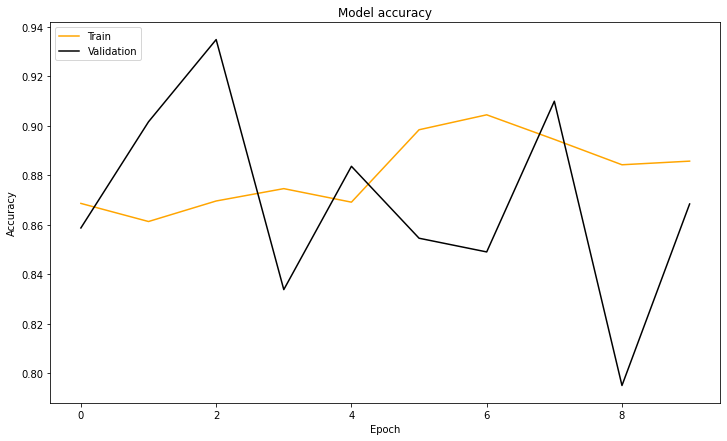

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(history.history['accuracy'], c = "orange")
ax.plot(history.history['val_accuracy'], c = "black")
ax.set_title('Model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

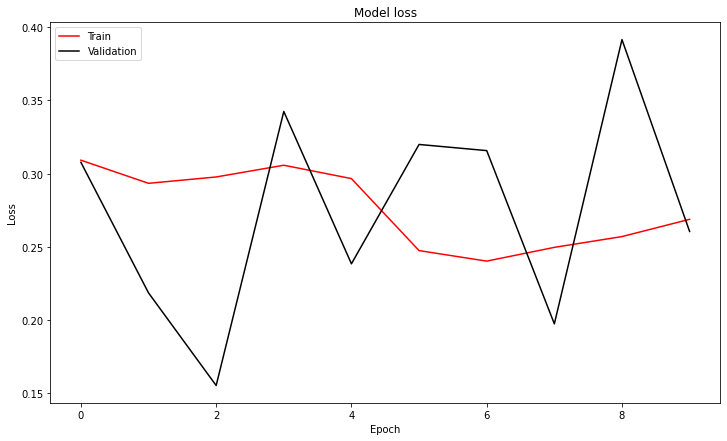

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(history.history['loss'], c ="red")
ax.plot(history.history['val_loss'], c = "black")
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()